In [2]:
import pylab
import calendar
import numpy as np
import seaborn as sn
import pandas as pd
from scipy import stats
# import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment=None
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [3]:
dailyData = pd.read_csv('C:/Users/hwali/kaggle/bike-sharing-demand/train.csv')

In [4]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Data Summary

In [5]:
dailyData.shape

(10886, 12)

In [6]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# Feature Engineering

In [7]:
# create new columns 'date','hour','weekday','month' from 'datetime' column
# 'season','holiday','workingday' and weather to category
# drop the datetime columns as we already extracted useful features from it

dailyData['date'] = dailyData['datetime'].apply(lambda x: x.split()[0])
dailyData['hour'] = dailyData['datetime'].apply(lambda x: x.split()[1])
dailyData['weekday'] = dailyData['date'].apply(lambda x: calendar.day_name[datetime.strptime(x,'%Y-%m-%d').weekday()])
# calendar module 사용하기
# list(calendar.day_name)
# map 함수(키, 밸류로 매핑)
dailyData['month'] = dailyData['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])
dailyData['season'] = dailyData['season'].map({1:"Spring", 2: "Summer", 3: "Fall", 4: "Winter"})
dailyData['weather'] = dailyData['weather'].map({1:"Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                                2: "Mist+Cloudy, Mist + Broken clouds, Mist+Few clouds, Mist",\
                                                3: "Light Snow,Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                                4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })


# Coercing To Category Type

In [8]:
categoryVariableList = ['hour','weekday','month','season','weather','holiday','workingday']
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

# Dropping Unnecessary Columns

In [9]:
dailyData = dailyData.drop(['datetime'],axis=1)

In [10]:
dailyData.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

# visualization

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot Working Day')]

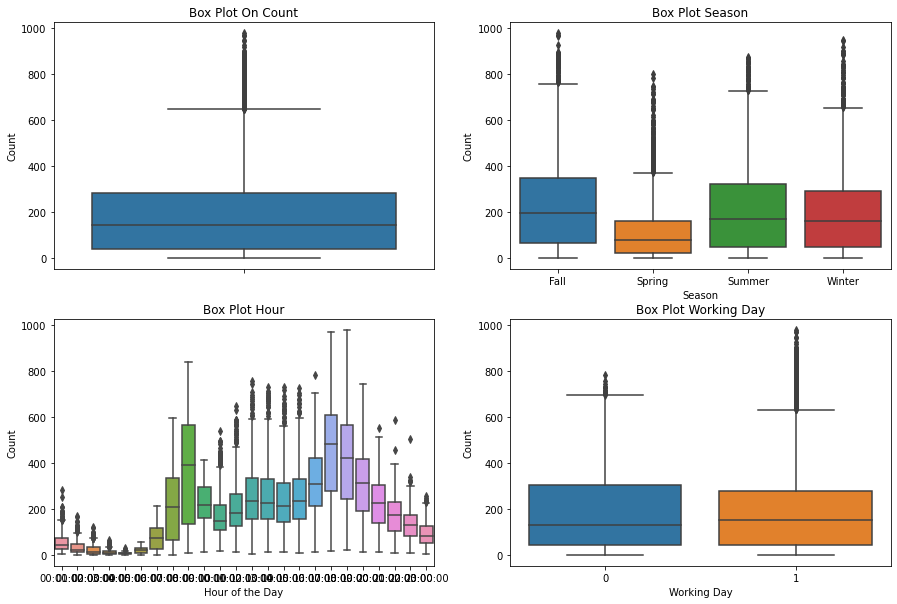

In [11]:
fig,axes = plt.subplots(2,2)
fig.set_size_inches(15,10)
sn.boxplot(data=dailyData,y='count',orient='v',ax=axes[0][0])
sn.boxplot(data=dailyData, y='count',x='season',orient='v',ax=axes[0][1])
sn.boxplot(data=dailyData, y='count',x='hour',orient='v',ax=axes[1][0])
sn.boxplot(data=dailyData, y='count',x='workingday',orient='v',ax=axes[1][1])

axes[0][0].set(ylabel='Count',title='Box Plot On Count')
axes[0][1].set(xlabel='Season',ylabel='Count',title='Box Plot Season')
axes[1][0].set(xlabel='Hour of the Day',ylabel='Count',title='Box Plot Hour')
axes[1][1].set(xlabel='Working Day',ylabel='Count',title='Box Plot Working Day')

# Remove Outliers In the Count Column

In [12]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData['count']-dailyData['count'].mean())<=(3*dailyData['count'].std())]

In [13]:
print("Shape Of the Before Outliers:",dailyData.shape)
print("Shape of the After Outliers:",dailyDataWithoutOutliers.shape)

Shape Of the Before Outliers: (10886, 15)
Shape of the After Outliers: (10739, 15)


# Correlation Analysis

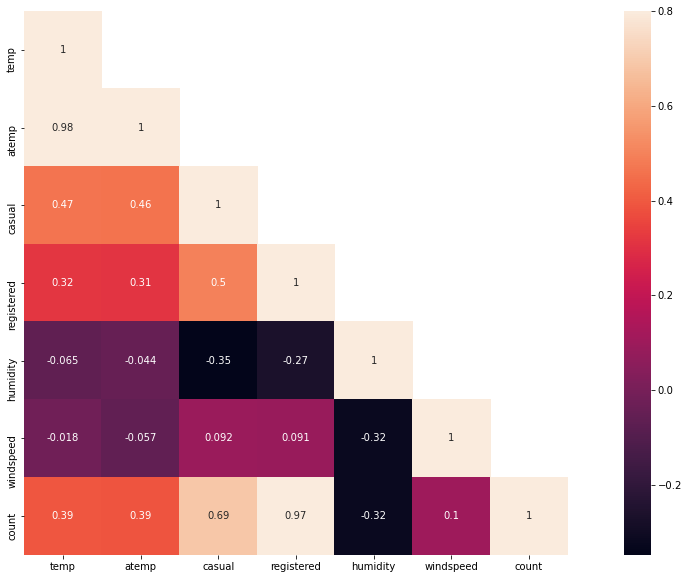

In [14]:
# 상관관계 분석은 연속형 데이터에 대해서만 가능
# 상관계수 시각화 할 때는 한쪽 삼각형만 나타내는 것이 깔끔
corrMatt = dailyData[['temp','atemp','casual','registered','humidity','windspeed','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]=False
fig,ax = plt.subplots(figsize=(20,10))
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

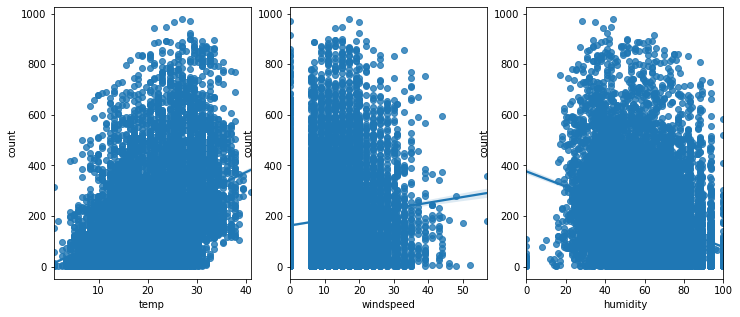

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))
sn.regplot(x='temp',y='count',data=dailyData, ax=ax1)
sn.regplot(x='windspeed',y='count',data=dailyData, ax=ax2)
sn.regplot(x='humidity',y='count',data=dailyData,ax=ax3)

# Visualizing Distribution of Data

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

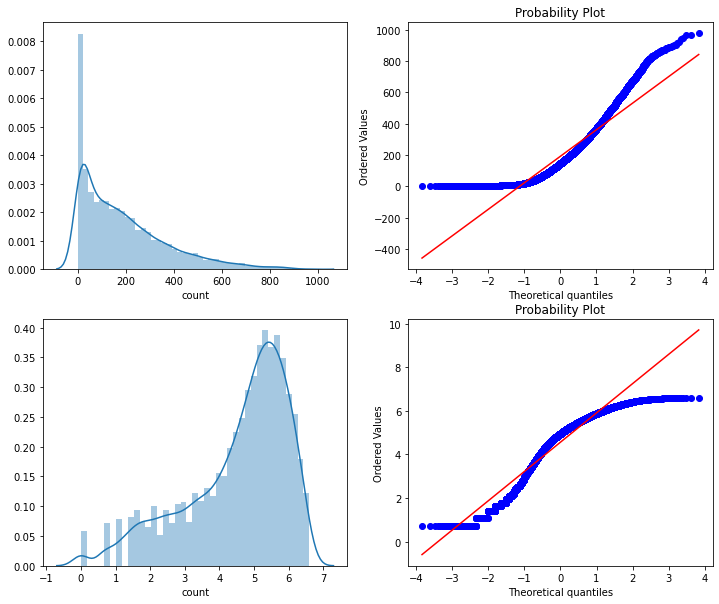

In [16]:
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
# distplot 명령은 러그와 커널 밀도 표시 기능이 있어서 matplotlib의 hist 명령보다 많이 사용
sn.distplot(dailyData['count'],ax=axes[0][0])
# Q-Q플롯을 계산하고 그리기 위해서 probplot사용
stats.probplot(dailyData['count'],dist='norm',fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers['count']),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers['count']),dist='norm',fit=True,plot=axes[1][1])

# Visualizing Count Vs
(Month, Season, Weekday, Usertype)

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of the Day Across User Type'),
 None]

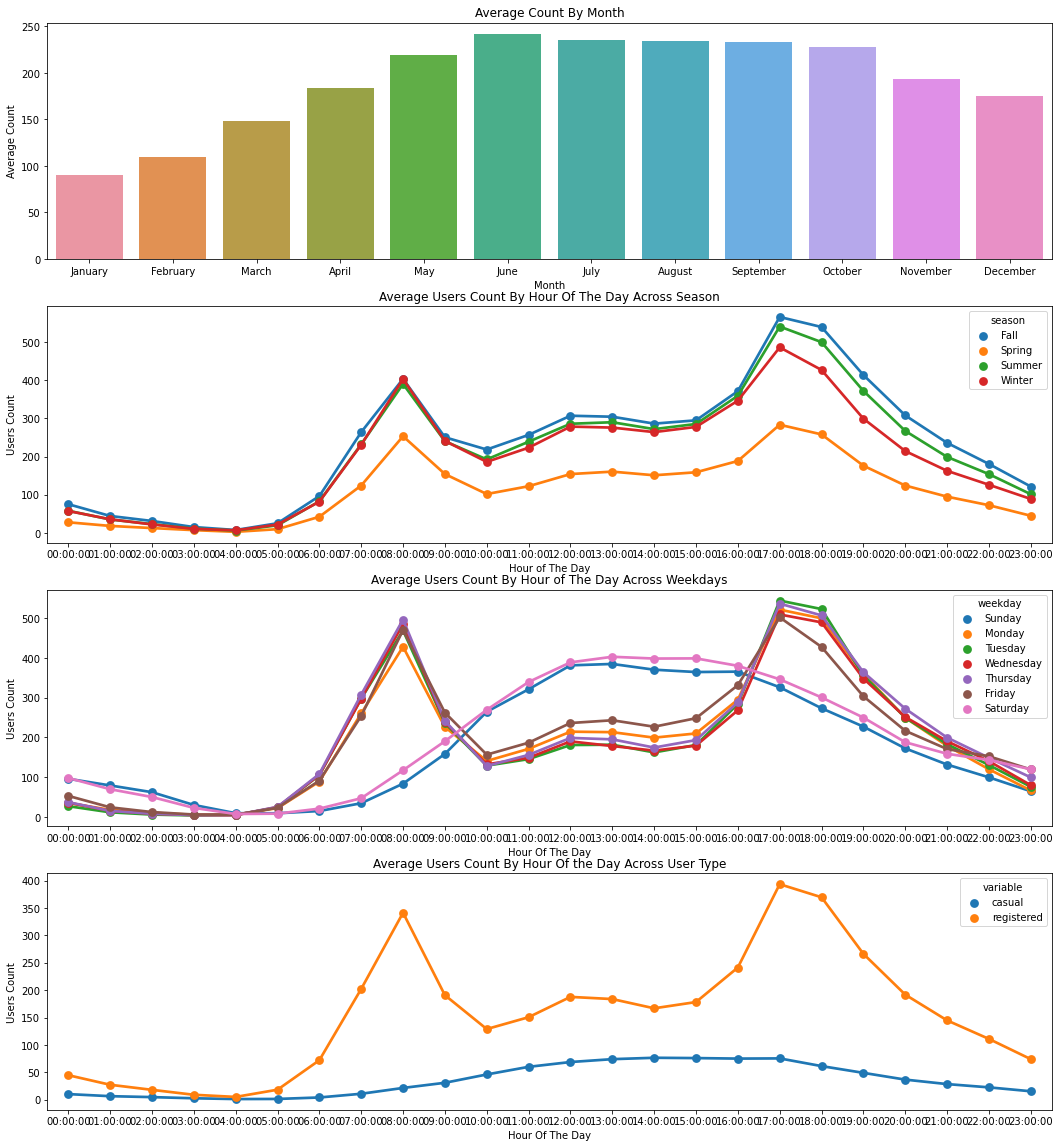

In [17]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, figsize=(18,20))
sortOrder = ['January','February','March','April','May','June','July','August',
            'September','October','November','December']
hueOrder = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# reset_index(): 기존의 행 인덱스를 제거하고 인덱스를 데이터 열로 추가
monthAggregated = pd.DataFrame(dailyData.groupby('month')['count'].mean()).reset_index()
monthSorted = monthAggregated.sort_values(['count'],ascending=False)
# sortOrder
sn.barplot(data=monthSorted, x='month',y='count',ax=ax1, order=sortOrder)
ax1.set(xlabel='Month',ylabel='Average Count',title='Average Count By Month')

hourAggregated = pd.DataFrame(dailyData.groupby(['hour','season'],sort=True)
                              ['count'].mean()).reset_index()
sn.pointplot(x=hourAggregated['hour'], y=hourAggregated['count'],hue=hourAggregated['season'],data=hourAggregated,join=True, ax=ax2)
ax2.set(xlabel='Hour of The Day',ylabel='Users Count',title='Average Users Count By Hour Of The Day Across Season',label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(['hour','weekday'],sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hourAggregated['hour'], y=hourAggregated['count'],hue=hourAggregated['weekday'],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day',ylabel='Users Count',title='Average Users Count By Hour of The Day Across Weekdays',label='big')

hourTransformed = pd.melt(dailyData[['hour','casual','registered']],id_vars=['hour'],value_vars=['casual','registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index()
sn.pointplot(x=hourAggregated['hour'],y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'],data=hourAggregated,join=True, ax=ax4)
ax4.set(xlabel='Hour Of The Day',ylabel='Users Count',title='Average Users Count By Hour Of the Day Across User Type',label='big')


# Let's Read In Train And Test Data

In [18]:
dataTrain = pd.read_csv("C://Users//hwali//kaggle//bike-sharing-demand//train.csv")
dataTest = pd.read_csv("C://Users//hwali//kaggle//bike-sharing-demand//test.csv")

In [19]:
# Combine Train And Test
data = dataTrain.append(dataTest)
data.reset_index(inplace=True) # inplace는 원본 객체를 변경할 지 여부 결정
data.drop('index',inplace=True, axis=1)

In [20]:
#Feature Engineering
data['date'] = data.datetime.apply(lambda x: x.split()[0])
data['hour'] = data.datetime.apply(lambda x: x.split()[1].split(":")[0]).astype("int")
data['year'] = data.datetime.apply(lambda x: x.split()[0].split("-")[0])
data['weekday'] = data.date.apply(lambda dateString: datetime.strptime(dateString,'%Y-%m-%d').weekday())
data['month'] = data.date.apply(lambda dateString: datetime.strptime(dateString,'%Y-%m-%d').month)
       

# Random Forest Model To Predict 0's in Windspeed

In [21]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed']==0] # windspeed가 0인 것
dataWindNot0 = data[data['windspeed']!=0] # windspeed가 0이 아닌 것
rfModel_wind = RandomForestRegressor()
windColumns = ['season','weather','humidity','month','temp','year','atemp']
rfModel_wind.fit(dataWindNot0[windColumns],dataWindNot0['windspeed'])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0['windspeed'] = wind0Values # 예측한 값으로 대체(windspeed가 0인 것 대체)
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True, axis=1)
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.003200,0.0,1.0,1.0,2011-01-01,5,2011,5,1
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.997900,12.0,24.0,36.0,2011-01-01,10,2011,5,1
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.001200,26.0,30.0,56.0,2011-01-01,11,2011,5,1
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.001200,29.0,55.0,84.0,2011-01-01,12,2011,5,1
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.999500,47.0,47.0,94.0,2011-01-01,13,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,9.581430,NaN,NaN,NaN,2012-12-29,12,2012,5,12
17375,2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,9.581430,NaN,NaN,NaN,2012-12-29,13,2012,5,12
17376,2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,7.682119,NaN,NaN,NaN,2012-12-29,15,2012,5,12
17377,2012-12-29 23:00:00,1,0,0,2,10.66,12.120,60,25.241275,NaN,NaN,NaN,2012-12-29,23,2012,5,12


# Coercing To Categorical Type

In [22]:
categoricalFeatureNames = ['season','holiday','workingday','weather','weekday','month','year','hour']
numericalFeatureNames = ['temp','humidity','windspeed','atemp']
dropFeatures = ['casual','count','datetime','date','registered']

In [23]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

# Splitting Train And Test Data

In [24]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=['datetime']) #null이 아닌 것만 뽑아내기
dataTest = data[~pd.notnull(data['count'])].sort_values(by=['datetime']) # null이 있는 것만 뽑아내기
datetimecol = dataTest['datetime']
yLabels = dataTrain['count']
yLablesRegistered = dataTrain['registered']
yLablesCasual = dataTrain['casual']


In [25]:
dataTrain = dataTrain.drop(dropFeatures,axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

# RMSLE Scorer

In [26]:
def rmsle(y,y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc = (log1-log2) **2
    return np.sqrt(np.mean(calc))

# Linear Regression Model

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(dataTrain, yLabelsLog)

# Make predictions
preds = lModel.predict(dataTrain)
print("RMSLE Value For Linear Regression:",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression: 0.9779619588776324


# Regularization Model-Ridge

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression: 0.9779619438063459


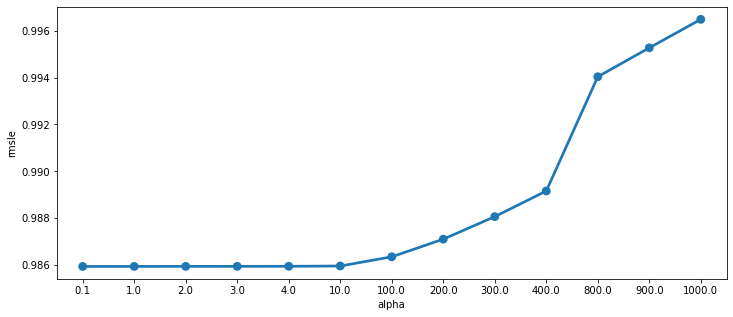

In [28]:
ridge_m_ = Ridge()
ridge_params_ ={'max_iter':[3000],'alpha':[0.1,1,2,3,4,10,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                           ridge_params_,
                           scoring = rmsle_scorer,
                           cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit(dataTrain,yLabelsLog)
preds = grid_ridge_m.predict(X=dataTrain)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression:",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(grid_ridge_m.cv_results_) # grid_scores_  -> cv_results_
df['alpha'] = df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)
sn.pointplot(data=df, x='alpha',y='rmsle',ax=ax)

# Regularization Model-Lasso

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression: 0.978099075316048


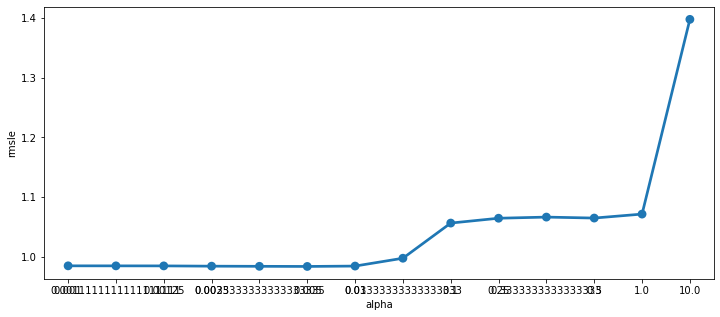

In [29]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV(lasso_m_,lasso_params_,scoring=rmsle_scorer, cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain,yLabelsLog)
preds = grid_lasso_m.predict(dataTrain)
print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression:",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(grid_lasso_m.cv_results_)
df['alpha'] = df['params'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)
sn.pointplot(data=df, x='alpha',y='rmsle',ax=ax)

# Ensemble Models-Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100, max_depth=30)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(dataTrain)
print("RMSLE Value For Random Forest:",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest: 0.10414926689075385


# Ensemble Model-Gradient Boost

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(dataTrain)
print("RMSLE Value For Random Forest:",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest: 0.18896750246543095


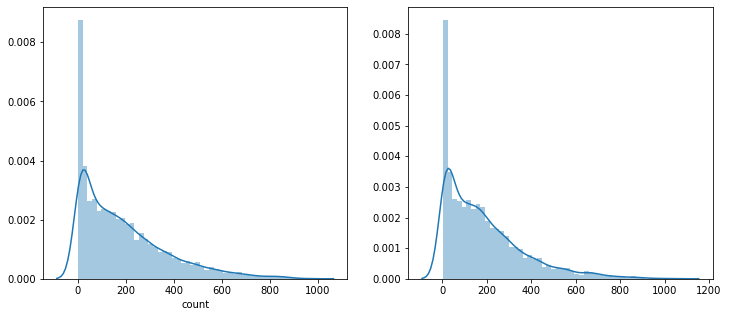

In [45]:
predsTest = gbm.predict(dataTest)
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [43]:
submission = pd.DataFrame({'datetime':datetimecol,
                          'count':[max(0,x) for x in np.exp(predsTest)]})
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv',index=False)